In [41]:
import numpy as np
import pandas as pd
#from scipy.stats import truncnorm
from sklearn.preprocessing import PolynomialFeatures



In [42]:

def get_covariance_matrix(p: int, mean_correlation: float=0.3):

    mean = np.zeros(p)
    ''' Get n*n covariance matrix '''
    variance_diagonal = np.ones(p) # in principle, n could be n draws from some meta-distribution
    matrix = np.zeros((p, p))       
    # assign variance to diagonal
    
    while True:
        try:
            for i in range(p): #columns
                matrix[i, i] = variance_diagonal[i]

                for j in range(i+1, p):
                    correlation = np.clip(np.random.normal(mean_correlation, 0.01), -1, 1)
                    #print(f"Correlation: {correlation}")
                    matrix[i, j] = matrix[j, i] = correlation *  np.sqrt(variance_diagonal[i] * variance_diagonal[j])

            pos_def_test = np.linalg.cholesky(matrix)    

        except np.linalg.LinAlgError:
            continue
    
        break


    return matrix, mean

cov = get_covariance_matrix(100, mean_correlation=0.2)


In [43]:
def get_dataframe(cov: np.ndarray, mean: np.ndarray, p: int, n:int = 5000 ) -> np.ndarray:
    
    rng = np.random.default_rng()
    multivariate_samples = rng.multivariate_normal(mean, cov, n)
    df = pd.DataFrame(multivariate_samples, columns=[f"X{i}" for i in range(p)])
    return df

p = 100
cov, mean = get_covariance_matrix(p, mean_correlation=0.2)

df = get_dataframe(cov, mean, p)
df["T"] = np.random.binomial(1, 0.5, len(df))

df_og = df.copy()

In [33]:
def gen_mu_x(p: int, df: pd.DataFrame, n: int=5000) -> pd.DataFrame:

    feat_no = int(p/2)

    columns = [f"X{i}" for i in range(feat_no)]
    poly = PolynomialFeatures(interaction_only=True)

    poly_features = poly.fit_transform(df[columns])
    print(poly_features.shape)
    sum_poly_features = poly_features.sum(axis=1)

    df['mu_x'] = sum_poly_features + np.random.normal(0, 1, n)

    return df

gen_mu_x(100, df)
df

(5000, 1276)


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X94,X95,X96,X97,X98,X99,T,mu_x,CATE,y
0,1.551286,-0.746793,-0.924284,2.037757,-0.700409,1.371969,1.031722,0.298255,1.247888,1.261272,...,-1.044110,-0.850166,0.550537,1.245716,0.315260,0.070038,0,481.010709,0.000000,482.283760
1,0.659031,0.204431,-0.172225,1.381654,0.434518,0.469731,-0.374859,0.656928,-1.968334,0.607109,...,0.423553,-1.154891,1.232535,0.558099,-1.062581,-0.182974,1,6.032895,45.317484,51.137784
2,-0.664385,-1.332737,-1.097366,-2.693655,-1.236997,-0.621260,-0.150529,-1.270034,-0.040846,-0.659039,...,0.617000,-0.914873,-1.014374,-1.291196,0.335606,0.256769,0,854.014794,0.000000,857.703475
3,-0.410522,0.166962,-1.280621,-1.193665,-0.530022,-1.461462,-1.967317,-0.477428,-0.650726,-1.564726,...,-0.336575,-1.242224,-0.204006,-0.427128,-1.423165,-0.987758,1,752.843187,835.578492,1588.196935
4,-0.544447,0.472452,-1.216186,-1.750859,-0.428183,-0.759487,-0.342542,-0.306365,-1.566602,-0.448486,...,1.023029,-0.021049,0.071115,-0.752824,-0.000787,-0.754186,0,-26.733958,0.000000,-27.744608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.840567,-0.199716,-0.570257,0.507496,0.950645,-0.732413,1.362114,-1.361329,-0.456894,-0.319139,...,-1.236636,1.193232,-1.437452,0.654804,0.281426,-0.344802,1,-13.102578,16.287692,0.326461
4996,0.461279,-0.268172,-0.055199,-0.560504,0.292825,-0.584543,-0.177983,0.095895,0.161416,-1.138354,...,-0.695446,-0.546774,-0.651467,0.455981,0.125826,-1.767498,0,161.228309,0.000000,163.683229
4997,-1.946866,-0.569443,1.237336,-0.905239,-0.258773,0.010913,0.103788,0.098995,-0.721363,-0.132982,...,-1.257896,0.455030,-0.001152,0.582643,-0.902448,0.291152,0,-15.694263,0.000000,-15.336921
4998,-0.101218,-0.289437,0.318174,-1.951219,1.009027,-0.233655,-0.236978,-0.662499,0.670766,1.480309,...,0.340716,1.105509,0.877221,-0.068376,0.189072,-0.876749,1,283.905693,337.477136,623.767338


In [34]:
def gen_cate(p: int, degree: int, df: pd.DataFrame, n:int = 5000) -> pd.DataFrame: 
    
    feat_no = int(p/2)

    columns = [f"X{i}" for i in range(feat_no)]
    poly = PolynomialFeatures(degree)
    poly_features = poly.fit_transform(df[columns])

    # Sum the polynomial features along axis 1
    sum_poly_features = poly_features.sum(axis=1)

    print(poly_features.shape)

    # TODO: Add random weights to the sum of polynomial features (i.e., "coefficients"), maybe sin(SUM) 

    # Add the new variable to DataFrame
    df['CATE'] = (sum_poly_features + np.random.normal(0, 1, n))*df['T']

    return df

gen_cate(100, 2, df)

(5000, 1326)


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X94,X95,X96,X97,X98,X99,T,mu_x,CATE,y
0,1.551286,-0.746793,-0.924284,2.037757,-0.700409,1.371969,1.031722,0.298255,1.247888,1.261272,...,-1.044110,-0.850166,0.550537,1.245716,0.315260,0.070038,0,481.010709,0.000000,482.283760
1,0.659031,0.204431,-0.172225,1.381654,0.434518,0.469731,-0.374859,0.656928,-1.968334,0.607109,...,0.423553,-1.154891,1.232535,0.558099,-1.062581,-0.182974,1,6.032895,44.646683,51.137784
2,-0.664385,-1.332737,-1.097366,-2.693655,-1.236997,-0.621260,-0.150529,-1.270034,-0.040846,-0.659039,...,0.617000,-0.914873,-1.014374,-1.291196,0.335606,0.256769,0,854.014794,0.000000,857.703475
3,-0.410522,0.166962,-1.280621,-1.193665,-0.530022,-1.461462,-1.967317,-0.477428,-0.650726,-1.564726,...,-0.336575,-1.242224,-0.204006,-0.427128,-1.423165,-0.987758,1,752.843187,834.862081,1588.196935
4,-0.544447,0.472452,-1.216186,-1.750859,-0.428183,-0.759487,-0.342542,-0.306365,-1.566602,-0.448486,...,1.023029,-0.021049,0.071115,-0.752824,-0.000787,-0.754186,0,-26.733958,0.000000,-27.744608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.840567,-0.199716,-0.570257,0.507496,0.950645,-0.732413,1.362114,-1.361329,-0.456894,-0.319139,...,-1.236636,1.193232,-1.437452,0.654804,0.281426,-0.344802,1,-13.102578,15.400536,0.326461
4996,0.461279,-0.268172,-0.055199,-0.560504,0.292825,-0.584543,-0.177983,0.095895,0.161416,-1.138354,...,-0.695446,-0.546774,-0.651467,0.455981,0.125826,-1.767498,0,161.228309,0.000000,163.683229
4997,-1.946866,-0.569443,1.237336,-0.905239,-0.258773,0.010913,0.103788,0.098995,-0.721363,-0.132982,...,-1.257896,0.455030,-0.001152,0.582643,-0.902448,0.291152,0,-15.694263,0.000000,-15.336921
4998,-0.101218,-0.289437,0.318174,-1.951219,1.009027,-0.233655,-0.236978,-0.662499,0.670766,1.480309,...,0.340716,1.105509,0.877221,-0.068376,0.189072,-0.876749,1,283.905693,335.174787,623.767338


In [6]:
def gen_outcome(df: pd.DataFrame, n:int = 5000) -> pd.DataFrame:
    df['y'] = df['CATE'] + df['mu_x'] + np.random.normal(0, 1, n)
    return df

gen_outcome(df)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X94,X95,X96,X97,X98,X99,T,mu_x,CATE,y
0,1.551286,-0.746793,-0.924284,2.037757,-0.700409,1.371969,1.031722,0.298255,1.247888,1.261272,...,-1.044110,-0.850166,0.550537,1.245716,0.315260,0.070038,0,482.203524,0.000000,482.283760
1,0.659031,0.204431,-0.172225,1.381654,0.434518,0.469731,-0.374859,0.656928,-1.968334,0.607109,...,0.423553,-1.154891,1.232535,0.558099,-1.062581,-0.182974,1,7.339353,44.354083,51.137784
2,-0.664385,-1.332737,-1.097366,-2.693655,-1.236997,-0.621260,-0.150529,-1.270034,-0.040846,-0.659039,...,0.617000,-0.914873,-1.014374,-1.291196,0.335606,0.256769,0,856.019887,0.000000,857.703475
3,-0.410522,0.166962,-1.280621,-1.193665,-0.530022,-1.461462,-1.967317,-0.477428,-0.650726,-1.564726,...,-0.336575,-1.242224,-0.204006,-0.427128,-1.423165,-0.987758,1,754.312108,834.907747,1588.196935
4,-0.544447,0.472452,-1.216186,-1.750859,-0.428183,-0.759487,-0.342542,-0.306365,-1.566602,-0.448486,...,1.023029,-0.021049,0.071115,-0.752824,-0.000787,-0.754186,0,-26.897001,0.000000,-27.744608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.840567,-0.199716,-0.570257,0.507496,0.950645,-0.732413,1.362114,-1.361329,-0.456894,-0.319139,...,-1.236636,1.193232,-1.437452,0.654804,0.281426,-0.344802,1,-12.617820,14.752229,0.326461
4996,0.461279,-0.268172,-0.055199,-0.560504,0.292825,-0.584543,-0.177983,0.095895,0.161416,-1.138354,...,-0.695446,-0.546774,-0.651467,0.455981,0.125826,-1.767498,0,162.589567,0.000000,163.683229
4997,-1.946866,-0.569443,1.237336,-0.905239,-0.258773,0.010913,0.103788,0.098995,-0.721363,-0.132982,...,-1.257896,0.455030,-0.001152,0.582643,-0.902448,0.291152,0,-13.652611,0.000000,-15.336921
4998,-0.101218,-0.289437,0.318174,-1.951219,1.009027,-0.233655,-0.236978,-0.662499,0.670766,1.480309,...,0.340716,1.105509,0.877221,-0.068376,0.189072,-0.876749,1,286.024052,337.068139,623.767338


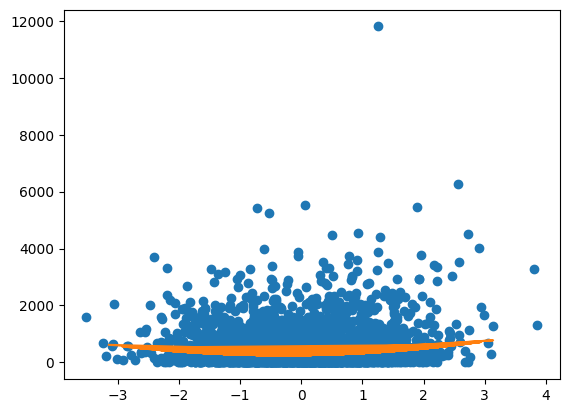

In [23]:
import matplotlib.pyplot as plt
import numpy as np


df_treat = df[df["T"] == 1]
x_var = df_treat["X23"]
plt.plot(x_var, df_treat["y"], 'o')
# fit polynomial regression
poly_fit = np.polyfit(x_var, df_treat["CATE"],2 )
poly_fit_fn = np.poly1d(poly_fit)
plt.plot(df_treat["X0"], poly_fit_fn(df_treat["X0"]))


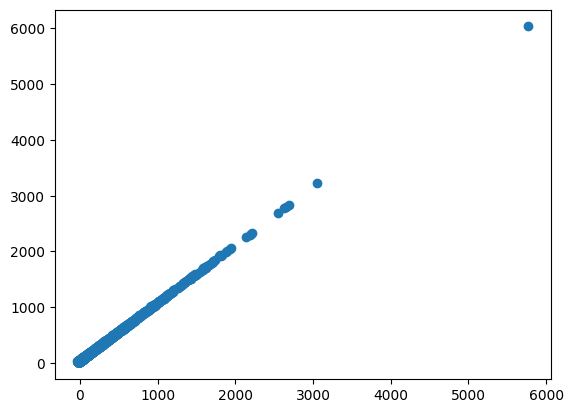

In [32]:
df_nontreat = df[df["T"] == 0]
#plt.plot(df_nontreat["y"], df_nontreat["mu_x"], 'o')
# add 45 degree line
#plt.plot([0, 1], [0, 1], 'r-')

plt.plot(df_treat["mu_x"], df_treat["CATE"], 'o')

In [44]:
df_100_2 = gen_cate(100, 2, df_og)
df_50_3 = gen_cate(50, 3, df_og)

#%%



(5000, 1326)
(5000, 3276)


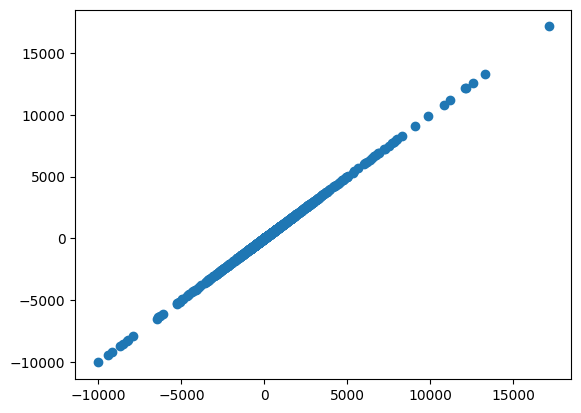

In [46]:
plt.plot(df_100_2["CATE"], df_50_3["CATE"], 'o')